In [ ]:
!pip install numpy pandas matplotlib seaborn opencv-python-headless tensorflow scikit-learn keras


In [ ]:
!pip install tabulate

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import os


In [ ]:
from tensorflow import keras
from keras.layers import Dense, Dropout,Flatten,MaxPooling2D,Conv2D, BatchNormalization, Activation
from keras.models import Sequential, load_model, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.regularizers import l2

from keras.callbacks import ReduceLROnPlateau

In [ ]:
from keras.optimizers import Adam
from keras.utils import to_categorical

In [ ]:
from google.colab import files

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sachin099","key":"f6bd9b7688a5358dcddbe233aa83f959"}'}

In [ ]:
!mkdir ~/.kaggle
!mv /content/kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!pip install kaggle

In [ ]:
!kaggle datasets download -d preetviradiya/covid19-radiography-dataset

Dataset URL: https://www.kaggle.com/datasets/preetviradiya/covid19-radiography-dataset
License(s): GPL-2.0
100% 746M/747M [00:41<00:00, 22.6MB/s]
100% 747M/747M [00:41<00:00, 18.8MB/s]


In [ ]:
!unzip /content/covid19-radiography-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset/Normal/Normal-671.png  
  inflating: COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset/Normal/Normal-6710.png  
  inflating: COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset/Normal/Normal-6711.png  
  inflating: COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset/Normal/Normal-6712.png  
  inflating: COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset/Normal/Normal-6713.png  
  inflating: COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset/Normal/Normal-6714.png  
  inflating: COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset/Normal/Normal-6715.png  
  inflating: COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset/Normal/Normal-6716.png  
  inflating: COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset/Normal/Normal-6717.png  
  inflating: COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset/Normal/Normal-6

In [ ]:
data=pd.read_csv("/content/metadata.csv")

In [ ]:
data

,Unnamed: 0,file_name,image_data_grayscale,file_format,image_shape,label
0,0,COVID-1.png,[[185 40 0 ... 0 24 131]\n [ 75 14 0 ...,PNG,"(299, 299)",COVID
1,1,COVID-10.png,[[135 133 131 ... 24 21 19]\n [132 130 129 ...,PNG,"(299, 299)",COVID
2,2,COVID-100.png,[[ 62 10 0 ... 197 200 209]\n [ 35 6 0 ...,PNG,"(299, 299)",COVID
3,3,COVID-1000.png,[[162 162 162 ... 4 4 5]\n [ 26 26 26 ...,PNG,"(299, 299)",COVID
4,4,COVID-1001.png,[[ 0 0 0 ... 0 0 0]\n [ 0 0 0 ...,PNG,"(299, 299)",COVID
...,...,...,...,...,...,...
21160,21160,Viral Pneumonia-995.png,[[ 3 4 7 ... 62 61 59]\n [ 2 3 6 ... 64 61...,PNG,"(299, 299)",Viral Pneumonia
21161,21161,Viral Pneumonia-996.png,[[30 41 45 ... 66 63 60]\n [32 43 48 ... 67 64...,PNG,"(299, 299)",Viral Pneumonia
21162,21162,Viral Pneumonia-997.png,[[17 15 9 ... 93 96 98]\n [23 19 13 ... 91 92...,PNG,"(299, 299)",Viral Pneumonia
21163,21163,Viral Pneumonia-998.png,[[0.37254902 0.37647059 0.38431373 ... 0.47058...,PNG,"(299, 299)",Viral Pneumonia


In [ ]:
base_dir ='/content/COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset'
categories = ['Normal', 'Lung_Opacity', 'COVID', 'Viral Pneumonia']

# Initialize a dictionary to store the counts
image_counts = {category: 0 for category in categories}

# Traverse each category directory and count the images
for category in categories:
    category_dir = os.path.join(base_dir, category)
    if os.path.exists(category_dir):
        image_counts[category] = len([file for file in os.listdir(category_dir) if file.endswith('.png')])

# Create a DataFrame to display the counts
df = pd.DataFrame(list(image_counts.items()), columns=['Category', 'Image Count'])

# Add a row for the total count
total_count = df['Image Count'].sum()
total_df = pd.DataFrame([['Total', total_count]], columns=['Category', 'Image Count'])

# Concatenate the total row with the original DataFrame
df = pd.concat([df, total_df], ignore_index=True)

# Display the table
from tabulate import tabulate
print(tabulate(df, headers='keys', tablefmt='pretty'))

+---+-----------------+-------------+
|   |    Category     | Image Count |
+---+-----------------+-------------+
| 0 |     Normal      |    10192    |
| 1 |  Lung_Opacity   |    6012     |
| 2 |      COVID      |    3616     |
| 3 | Viral Pneumonia |    1345     |
| 4 |      Total      |    21165    |
+---+-----------------+-------------+


In [ ]:
image_paths = []
labels = []

# Traverse each category directory and collect image paths and labels
for category in categories:
    category_dir = os.path.join(base_dir, category)
    if os.path.exists(category_dir):
        for file in os.listdir(category_dir):
            if file.endswith('.png'):
                image_paths.append(os.path.join(category_dir, file))
                labels.append(category)

# Create a DataFrame to store the image paths and labels
df = pd.DataFrame({'image_path': image_paths, 'label': labels})

In [ ]:
df

,image_path,label
0,/content/COVID-19_Radiography_Dataset/COVID-19...,Normal
1,/content/COVID-19_Radiography_Dataset/COVID-19...,Normal
2,/content/COVID-19_Radiography_Dataset/COVID-19...,Normal
3,/content/COVID-19_Radiography_Dataset/COVID-19...,Normal
4,/content/COVID-19_Radiography_Dataset/COVID-19...,Normal
...,...,...
21160,/content/COVID-19_Radiography_Dataset/COVID-19...,Viral Pneumonia
21161,/content/COVID-19_Radiography_Dataset/COVID-19...,Viral Pneumonia
21162,/content/COVID-19_Radiography_Dataset/COVID-19...,Viral Pneumonia
21163,/content/COVID-19_Radiography_Dataset/COVID-19...,Viral Pneumonia


In [ ]:
# Split the dataset into training, validation, and test sets
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['label'], random_state=42)

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")


Training set size: 13545
Validation set size: 3387
Test set size: 4233


In [ ]:
# Define image data generators with data augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation and test sets will only be rescaled
val_test_datagen = ImageDataGenerator(rescale=1.0/255)

In [ ]:
# Define image size and batch size
img_size = (224, 224)
batch_size = 32

# Create data generators
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='image_path',
    y_col='label',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_dataframe(
    val_df,
    x_col='image_path',
    y_col='label',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_dataframe(
    test_df,
    x_col='image_path',
    y_col='label',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 13545 validated image filenames belonging to 4 classes.
Found 3387 validated image filenames belonging to 4 classes.
Found 4233 validated image filenames belonging to 4 classes.


In [ ]:
def create_cnn_model(input_shape, num_classes):
    model = Sequential()

    # First convolutional layer
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    # Second convolutional layer
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    # Third convolutional layer
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    # Flatten the output and add fully connected layers
    model.add(Flatten())
    model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    return model

# Define input shape and number of classes
input_shape = (224, 224, 3)  # Adjust based on your image size and channels
num_classes = len(categories)  # Adjust based on the number of categories

# Create the model
model = create_cnn_model(input_shape, num_classes)


In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 111, 111, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 64)      2

In [ ]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=20,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

# Load the best model
model.load_weights('best_model.h5')


Epoch 1/20
424/424 [==============================] - ETA: 0s - loss: 3.2586 - accuracy: 0.5506

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


424/424 [==============================] - 231s 523ms/step - loss: 3.2586 - accuracy: 0.5506 - val_loss: 3.0036 - val_accuracy: 0.3587 - lr: 0.0010
Epoch 2/20
424/424 [==============================] - 207s 488ms/step - loss: 2.2205 - accuracy: 0.6018 - val_loss: 2.0188 - val_accuracy: 0.5258 - lr: 0.0010
Epoch 3/20
424/424 [==============================] - 205s 483ms/step - loss: 1.9315 - accuracy: 0.6383 - val_loss: 2.0868 - val_accuracy: 0.5515 - lr: 0.0010
Epoch 4/20
424/424 [==============================] - 211s 498ms/step - loss: 1.9868 - accuracy: 0.6447 - val_loss: 1.9453 - val_accuracy: 0.6153 - lr: 0.0010
Epoch 5/20
424/424 [==============================] - 203s 478ms/step - loss: 1.9359 - accuracy: 0.6444 - val_loss: 3.7029 - val_accuracy: 0.4833 - lr: 0.0010
Epoch 6/20
424/424 [==============================] - 207s 488ms/step - loss: 2.0135 - accuracy: 0.6435 - val_loss: 3.2844 - val_accuracy: 0.4813 - lr: 0.0010
Epoch 7/20
424/424 [==============================] - 208

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Save the model to Google Drive
model.save('/content/drive/MyDrive/my_model.keras')


In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


133/133 [==============================] - 15s 114ms/step - loss: 1.0049 - accuracy: 0.8268
Test Loss: 1.0049266815185547
Test Accuracy: 0.8268367648124695


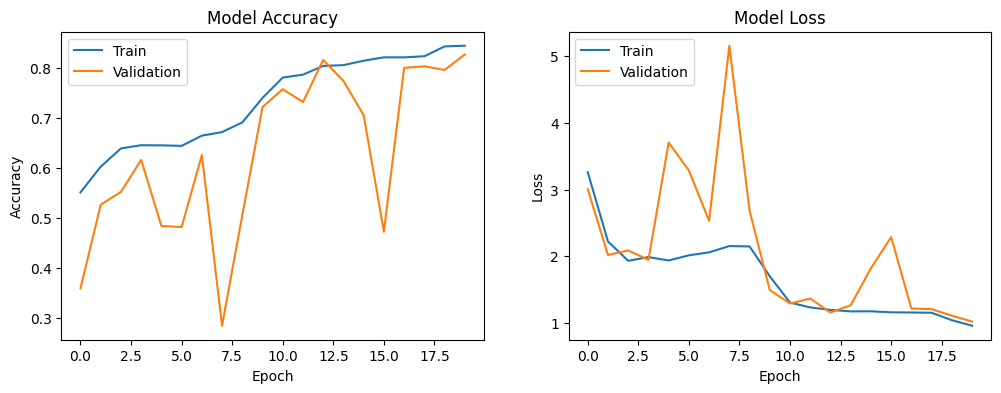

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


In [ ]:
# Make predictions on the test set
predictions = model.predict(test_generator, steps=len(test_generator))

# Convert predictions to class labels
predicted_classes = predictions.argmax(axis=-1)

# Get true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Print a classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)


133/133 [==============================] - 13s 99ms/step
                 precision    recall  f1-score   support

          COVID       0.86      0.59      0.70       723
   Lung_Opacity       0.76      0.82      0.79      1203
         Normal       0.84      0.93      0.89      2038
Viral Pneumonia       0.98      0.69      0.81       269

       accuracy                           0.83      4233
      macro avg       0.86      0.76      0.80      4233
   weighted avg       0.83      0.83      0.82      4233



In [ ]:
'''
from google.colab import drive
drive.mount('/content/drive')

from tensorflow.keras.models import load_model

# Load the model from Google Drive
model = load_model('/content/drive/MyDrive/my_model.keras')
'''

"\nfrom google.colab import drive\ndrive.mount('/content/drive')\n\nfrom tensorflow.keras.models import load_model\n\n# Load the model from Google Drive\nmodel = load_model('/content/drive/MyDrive/my_model.keras')\n"